# Python Notebook for calculations likelihood root-based attacks against maximal real extensions of the forn $n = 2^r \cdot p^s$

# Dependencies

In [ ]:
# Initial dependencies to be used
!pip install galois, sympy, joblib, math, numpy

In [1]:
# work with number fields, primes
import galois, sympy
# parallelized executions
from joblib import Parallel, delayed
# useful math functions for root-based calculations
from math import erf, ceil, sqrt, floor
# Chebychev factorization
import numpy as np
# Big numbers
import decimal
#Pickle data
import pickle
#Random subset selection
import random
# Graphs
import matplotlib.pyplot as plt

# Initial Definitions and Auxiliary Processes

To analyze the case of roots over small finite extensions of $\mathbb{F}_q$, and in an attempt to bring down the computational cost of finding roots, we will in this section get the factors of the maximal real polynomial

In [ ]:
#Chebychev for the sum of T_i(x) terms
cheb = np.polynomial.chebyshev.Chebyshev([1,1,1])
print(cheb)

We construct the modified chebychev polynomials of the form $V_i(x) = 2 \cdot T_i(x/2)$ is. First, we construct the first order Chebychev polynomials over finite fields. Then, extract the coefficients of the polynomials. And, lastly, interate over each to add the term $\frac{1}{2}^i$.

In [2]:
def cheb_ff_i(i, q):
    F = galois.GF(q)
    
    # Initial conditions
    T_0 = galois.Poly([1], field=F)
    T_1 = galois.Poly([1, 0], field=F)
    
    if i == 0:
        return T_0
    elif i == 1:
        return T_1
    else:
        aux_term = galois.Poly([2, 0], field=F)

        for i in range(2, i + 1):
            T_n = aux_term * T_1 - T_0
            T_0 = T_1
            T_1 = T_n
        return T_n

def mod_cheb_ff_i(i, q):
    F = galois.GF(q)
    if i == 0:
        return galois.Poly([1], field=F)
    else:
        T_n = cheb_ff_i(i, q)
        coeffs = []
        coef = [2*x for x in T_n.coeffs][::-1]
        for i in range(len(coef)):
            coeffs.append(coef[i] / (F(2)**i))
        return galois.Poly(coeffs[::-1], field=F)

Now, we define the minimal polynomials of the maximal real extensions in the cases $n = p^s$ and $n = 2^r \cdot p^s$

In [3]:
def minimal_polynomial_case_ps(p, s, q):
    F = galois.GF(q)
    k = (p-1)//2
    term = (p**(s-1))
    pol = galois.Poly([0], field=F)
    
    for i in range(0, k+1):
        coeff = i*term
        pol = pol + mod_cheb_ff_i(coeff, q)
    return pol

def minimal_polynomial_case_psr(p, s, r, q):
    #Case r = 0 represents n = p^s
    if r == 0:
        return minimal_polynomial_case_ps(p, s, q)
    F = galois.GF(q)
    k = (p-1)//2
    term = (p**(s-1)) * (2**(r-1))
    pol = galois.Poly([0], field=F)
    
    for i in range(0, k+1):
        coeff = i*term
        pol = pol + mod_cheb_ff_i(coeff, q)*galois.Poly([(-1)**(k-i)], field = F)
    return pol

In [4]:
p = 5
s = 1
r = 3
q = 7

x = 1

pol = minimal_polynomial_case_psr(p, s, r, q)
print(f'The result of the minimal polynomial {pol} at x = {x} for p = {p}, s = {s} and r = {r} in GF({q}) is {pol(x)}')

r = 0
pol = minimal_polynomial_case_psr(p, s, r, q)
print(f'The result of the minimal polynomial {pol} at x = {x} for p = {p}, s = {s} and r = {r} in GF({q}) is {pol(x)}')

The result of the minimal polynomial x^8 + 6x^6 + 5x^4 + 2x^2 + 1 at x = 1 for p = 5, s = 1 and r = 3 in GF(7) is 1
The result of the minimal polynomial x^2 + x + 6 at x = 1 for p = 5, s = 1 and r = 0 in GF(7) is 1


In [5]:
for x in pol.roots():
    print(f'Root x = {int(x)} with multiplicative order r = {x.multiplicative_order()}')

In [6]:
factors, multiplicities = pol.factors()

# Loop through the factors and their corresponding multiplicities
for factor, multiplicity in zip(factors, multiplicities):
    print(f"Factor {factor} of degree {factor.degree} with multiplicity {multiplicity}")

Factor x^2 + x + 6 of degree 2 with multiplicity 1


We also need to define the cylcotomic polynomial of associated degree to a certain configuration

Given that, for the n-th maximal real polynomial (being $n = 2^r \cdot p^s$), we need the $\frac{n}{2}$-th cyclotomic polynomial. For simplicity with regards to obtaining a formula for the aforementioned cyclotomic polynomial, we restrict to the case $n = 2^r \cdot p^s$ with $r \geq 2$

In [27]:
def cyclotomic_polynomial_case_psr(p, s, r, q):
    F = galois.GF(q)
    
    if r <= 1:
        # x - 1 as a dummy solution, it is not valid
        return galois.Poly([1, -1], field = F)

    l = s
    m = r - 1
    
    k = (p - 1)
    term = (p**(l-1)) * (2**(m-1))
    terms = [0 for x in range(0, k*term + 1)]
    for i in range(0, k+1):
        coeff = i*term
        terms[coeff] = ((-1)**i)
    
    return galois.Poly(terms[::-1], field=F)

In [57]:
r = 2
p = 5
s = 1
q = 7

print(f'Cyclotomic polynomial of n = 2^{r} * {p}^{s} in GF({q}): {cyclotomic_polynomial_case_psr(p, s, r, q)}')

Cyclotomic polynomial of n = 2^2 * 5^1 in GF(7): x^4 + 6x^3 + x^2 + 6x + 1


Now, we define the calculations for each of the root-based attacks that will be studied (over the base field $\mathbb{F}_q$ and finite small extensions of it):

* Attack on the Small Set of Error Values
* Attack on the Small Error Values
* Attack on the Small Error Values (Fully Probabilistic, Generalized)

In [5]:
#Small Set of Error Values Attack ratio

def likelihood_small_set(sigma, n, r, q):
    block = ((4*n*sigma) / r)
    # provision to handle 'extremely big' numbers
    if (block >= 1.4 and r >= 128) or n < r:
        return 1
    card_set = block**r
    return card_set/q

In [6]:
# Get Small Set of Error Values change of each instance

def process_outer_task_small_set_attack_chances(p, s, r, q, sigma, order):
    n = (2**(r-2))*(p**(s-1))*(p-1)
    return likelihood_small_set(sigma, n, order, q) < 1

# Main parallelized execution
def parallelized_task_small_set_attack_chances(list_total_info, sigma):
    list_chances_ssa = []
    results = Parallel(n_jobs=-1)(delayed(process_outer_task_small_set_attack_chances)(p, s, r, q, sigma, order)
                                  for (p, s, r, q, alpha, order) in list_total_info)
    for result in results:
        list_chances_ssa.append(result)
    return list_chances_ssa

def process_outer_task_small_set_attack_chances_k_ideals(p, s, r, q, sigma, order, k):
    if order == float('inf'):
        #not a real k-ideal factor
        return False
    # Account for k-division due to the trace
    n = (2**(r-2))*(p**(s-1))*(p-1)//k
    return likelihood_small_set(sigma, n, order, q) < 1

# Main parallelized execution
def parallelized_task_small_set_attack_chances_k_ideals(list_total_info, sigma):
    list_chances_ssa = []
    results = Parallel(n_jobs=-1)(delayed(process_outer_task_small_set_attack_chances_k_ideals)(p, s, r, q, sigma, order, k)
                                  for (p, s, r, q, value, order, k) in list_total_info)
    for result in results:
        list_chances_ssa.append(result)
    return list_chances_ssa

def small_err_set_attack_ratio(list_chances_ssa):
    return len([p for p in list_chances_ssa if p == True])/len(list_chances_ssa)

In [7]:
#Small Error Values Attack (with Fully Probabilistic Approach)

#Definitions of each distribution case
def case_distribution_1(n, sigma):
  quot = 1
  factor = (sigma**2)*n
  return sqrt(factor*quot)

def case_distribution_2(n, sigma, root, ord):
  quot = ((root**(2*ord)) - 1)//((root**2) - 1)
  factor = (n/ord)*(sigma**2)
  return sqrt(factor*quot)

def case_distribution_3(n, sigma, root):
  quot = ((root**(2*n)) - 1)//((root**2) - 1)
  factor = sigma**2
  return decimal.Decimal(factor*quot).sqrt()

# Auxiliary function to compute the integral that reigns over the success probability of the fully probabilistic approach
def A(r):
  return (erf(r/4))/2

def N(r):
  return (sqrt(2)/r) - (1/2)

def Bterm(k, r):
  return (erf(r*(k + (5/4))) - erf(r*(k + (3/4))))/2

def B(r):
  bound = N(r)
  value = 0.0
  for k in range(floor(bound)):
      value += Bterm(k , r)
  if bound > 0:
    correction_bound = bound - floor(bound)
    if correction_bound <= 1/4:
      correction_rate = 0
    elif correction_bound < 3/4:
      correction_rate = (erf(sqrt(2)) - erf(r*(floor(bound) + (3/4))))/2
    else:
      correction_rate = (erf(r*(floor(bound) + (5/4))) - erf(r*(floor(bound) + (3/4))))/2
    value += correction_rate
  return value

def I(r):
  return (A(r) + B(r))/(erf(sqrt(2))/2)

def Icota(r):
  return I(r) - 1/2

In [66]:
# Get Small Error Values change of each instance
def likelihood_small_err_values_chances(p, s, r, q, sigma, alpha, order):
    if alpha == None:
        # not a root
        return 0
    n = (2**(r-2))*(p**(s-1))*(p-1)
    if order == 1:
        sigma_image = case_distribution_1(n, sigma)
    elif order < 5:
        sigma_image = case_distribution_2(n, sigma, alpha, order)
    else:
        sigma_image = float(case_distribution_3(n, sigma, alpha))
    if (q/4 < 2*sigma_image):
        ratio = q/(sqrt(2) * sigma_image)
        if ratio < 1*(10**(-10)):
            return 0
        else:
            return Icota(ratio)
    else:
        return 1

# Main parallelized execution
def parallelized_task_small_err_values_chances(list_total_info, sigma):
    list_chances_sva = []
    results = Parallel(n_jobs=-1)(delayed(likelihood_small_err_values_chances)(p, s, r, q, sigma, alpha, order)
                                  for (p, s, r, q, alpha, order) in list_total_info)
    for result in results:
        list_chances_sva.append(result)
    return list_chances_sva

def likelihood_small_err_values_chances_k_ideals(p, s, r, q, sigma, value, order, k):
    if value == None:
        # not a real k-ideal factor
        return 0
    n = (2**(r-2))*(p**(s-1))*(p-1)//k
    if n < order:
        # n is supposed to be divisible by r (at least smaller), otherwise the computation does not make sense
        return 0
    if order == 1:
        sigma_image = case_distribution_1(n, sigma)
    elif order < 5:
        sigma_image = case_distribution_2(n, sigma, value, order)
    else:
        sigma_image = float(case_distribution_3(n, sigma, value))
    print(f'Sigma image: {sigma_image} on combination ({p}, {s}, {r}, {q}, {k}, {sigma})')
    if (q/4 < 2*sigma_image):
        ratio = q/(sqrt(2) * sigma_image)
        if ratio == 0:
            print(f'Ratio = 0')
            return 0
        else:
            print(f'Ratio = {Icota(ratio)}')
            return Icota(ratio)
    else:
        print(f'Ratio = 1')
        return 1

# Main parallelized execution
def parallelized_task_small_err_values_chances_k_ideals(list_total_info, sigma):
    list_chances_sva = []
    results = Parallel(n_jobs=-1)(delayed(likelihood_small_err_values_chances_k_ideals)(p, s, r, q, sigma, value, order, k)
                                  for (p, s, r, q, value, order, k) in list_total_info)
    for result in results:
        list_chances_sva.append(result)
    return list_chances_sva

def small_err_value_ratio(list_chances_sva):
    return len([p for p in list_chances_sva if p > 0])/len(list_chances_sva)

We introduce here the main process to extract all relevant information towards root-based attacks againt $\mathbb{F}_q$ or small finite extensions of it

In [9]:
# Get minimal polynomial roots info and k-ideals info for a certain setting

def process_outer_task_min_total_info(p, s, r, q, cyclotomic=False):
    # min pol
    if not cyclotomic:
        pol = minimal_polynomial_case_psr(p, s, r, q)
    else:
        pol = cyclotomic_polynomial_case_psr(p, s, r, q)
    total_info = []
    
    # roots info 
    list_roots_info = [(int(x), x.multiplicative_order()) for x in pol.roots()]

    # k-ideal factors info
    list_factors_info = []
    factors, multiplicities = pol.factors()
    for k in range(2, 5):
        list_terms = []
        for g in factors:
            if g.degree == k:
                non_zero_degrees = [int(x) for x in g.nonzero_degrees]
                if len(non_zero_degrees) == 2 and non_zero_degrees[1] == 0:
                    non_zero_coeffs = [x for x in g.nonzero_coeffs]
                    independent_term = int(-non_zero_coeffs[1])
                    order_independent_term = (-non_zero_coeffs[1]).multiplicative_order()
                    list_terms.append((independent_term, order_independent_term))
        list_factors_info.append((k, list_terms))

    total_info.append((p, s, r, q, list_roots_info, list_factors_info))
    #return all information
    return total_info

def parallelized_task_min_pol_total_info(list_triples, list_q_values):
    # get total info
    list_min_pols_total_info = []
    results = Parallel(n_jobs=-1)(delayed(process_outer_task_min_total_info)(p, s, r, q, False)
                                  for (p, s, r) in list_triples
                                  for q in list_q_values)

    for result in results:
        list_min_pols_total_info.extend(result)
    return list_min_pols_total_info

def parallelized_task_min_pol_total_info_cyclotomic(list_triples, list_q_values):
    # get total info
    list_min_pols_total_info = []
    results = Parallel(n_jobs=-1)(delayed(process_outer_task_min_total_info)(p, s, r, q, True)
                                  for (p, s, r) in list_triples
                                  for q in list_q_values)

    for result in results:
        list_min_pols_total_info.extend(result)
    return list_min_pols_total_info

In [10]:
def get_roots_info(list_total_info):
    list_roots_info = []
    for (p, s, r, q, roots, factors) in list_total_info:
        list_roots_info.append((p, s, r, q, roots))
    return list_roots_info

def get_factors_info(list_total_info):
    list_factors_info = []
    for (p, s, r, q, roots, factors) in list_total_info:
        list_factors_info.append((p, s, r, q, factors))
    return list_factors_info

Auxiliar function to load/save long computations

In [11]:
def save_data(data, filename):
    file = open(filename, 'wb')
    # dump information to that file
    pickle.dump(data, file)
    # close the file
    file.close()
    
def load_data(filename):
    # open a file, where you stored the pickled data
    file = open(filename, 'rb')
    # dump information to that file
    data = pickle.load(file)
    # close the file
    file.close()

    return data

# Techniques for study over $\mathbb{F}_q$ (i.e, using roots directly)

Next, we introduce the processes we will run in order to get the desired data:

* Number of instances with roots of small order (i.e. order < 5)
* Root of minimal order of each instance

In [12]:
# Number of small order roots in a certain instance

def process_outer_task_small_roots(p, s, r, q, roots):
    list_info = []

    for (x, order) in roots:
        if order < 5:
            list_info.append((p, s, r, q, x, order))
    return list_info

def parallelized_task_small_roots(list_min_pol_total_info):
    list_total_info = []
    list_min_pol_roots_info = get_roots_info(list_min_pol_total_info)
    
    results = Parallel(n_jobs=-1)(delayed(process_outer_task_small_roots)(p, s, r, q, roots)
                                  for (p, s, r, q, roots) in list_min_pol_roots_info)
    for result in results:
        list_total_info.extend(result)
    return list_total_info

In [13]:
# Smallest-order root of each instance

def process_outer_task_smallest_root(p, s, r, q, roots):
    list_info = []
    min_order = float('inf')
    best_root = None
    
    for (x, order) in roots:
        if order < min_order:
            best_root = x
            min_order = order
    list_info.append((p, s, r, q, best_root, min_order))
    return list_info

# Main parallelized execution
def parallelized_task_smallest_root(list_min_pol_total_info):
    list_total_info = []
    list_min_pol_roots_info = get_roots_info(list_min_pol_total_info)
    
    results = Parallel(n_jobs=-1)(delayed(process_outer_task_smallest_root)(p, s, r, q, roots)
                                  for (p, s, r, q, roots) in list_min_pol_roots_info)
    for result in results:
        list_total_info.extend(result)
    return list_total_info

# Techinques for study over finite extensions of $\mathbb{F}_q$ (of degree up to $k = 4$)

Here, we won't be interested in roots of the polynomials but, based upon the works of Blanco et al., on $k$-ideal factors, i.e. factors of the form $x^k + a$, were $a \in \mathbb{F}_q$ and of small order

Next, we introduce the processes we will run in order to get the desired data:

* Number of instances with k-ideal factors with independent element of small order (i.e. order < 5)
* k-ideal factor of minimal order of each instance

In [14]:
# Number of k-ideal factors in a certain instance

def process_outer_task_small_k_ideal_factors(p, s, r, q, factors):
    list_info = []

    for (k, elems) in factors:
        for (a, order) in elems:
            if order < 5:
                list_info.append((p, s, r, q, a, order, k))
    return list_info

def parallelized_task_small_k_ideal_factors(list_min_pol_total_info):
    list_total_info = []
    list_min_pol_factors_info = get_factors_info(list_min_pol_total_info)
    
    results = Parallel(n_jobs=-1)(delayed(process_outer_task_small_k_ideal_factors)(p, s, r, q, factors)
                                  for (p, s, r, q, factors) in list_min_pol_factors_info)
    for result in results:
        list_total_info.extend(result)
    return list_total_info

In [15]:
# Number of k-ideal factors in a certain instance

def process_outer_task_smallest_k_ideal_factors(p, s, r, q, factors):
    list_info = []

    for (k, elems) in factors:
        min_order = float('inf')
        best_term = None
        for (a, order) in elems:
            if order < min_order:
                min_order = order
                best_term = a
                        
        list_info.append((p, s, r, q, best_term, min_order, k))
    return list_info

def parallelized_task_smallest_k_ideal_factors(list_min_pol_total_info):
    list_total_info = []
    list_min_pol_factors_info = get_factors_info(list_min_pol_total_info)
    
    results = Parallel(n_jobs=-1)(delayed(process_outer_task_smallest_k_ideal_factors)(p, s, r, q, factors)
                                  for (p, s, r, q, factors) in list_min_pol_factors_info)
    for result in results:
        list_total_info.extend(result)
    return list_total_info

# Study over standardized setting of structured lattices (ML-KEM, ML-DSA and FN-DSA)

In [17]:
list_q_values = [3329, 12289, 8380417]
list_n_values = [256, 512, 1024]

First, we have to select some values of (p, s, r) which are closest to the values of $n$ to study (with the additional restriction of surpassing $n$).

In [ ]:
def closest_factors(n):
    primes = list(sympy.primerange(5, 2*n))
    
    best_r = 0
    best_p = 0
    best_s = 0
    best_diff = float('inf')
    
    for p in primes:
        s = 1
        while True:
            power_of_p = (p ** (s-1)) * ((p-1)//2) 
            if power_of_p - n > best_diff:
                break
    
            r = 2
            while 2 ** (r-1) * power_of_p - n <= best_diff:
                diff = 2 ** (r-1) * power_of_p - n
                if diff < best_diff and diff >= 0:
                    best_r, best_p, best_s = r, p, s
                    best_diff = diff
                r += 1
            s += 1
    
    return best_r, best_p, best_s

def closest_factors_no_r(n):
    primes = list(sympy.primerange(5, n + 1))
    
    best_r = 0
    best_p = 0
    best_s = 0
    best_diff = float('inf')
    
    for p in primes:
        s = 1
        while True:
            power_of_p = (p ** (s-1)) * ((p-1)//2) 
            if power_of_p - n > best_diff:
                break
    
            diff = power_of_p - n
            if diff < best_diff and diff >= 0:
                best_p, best_s = p, s
                best_diff = diff
            s += 1
    
    return best_r, best_p, best_s

In [ ]:
# Example usage:
n = 256
r, p, s = closest_factors(n)
print(f"For n = {n}, the closest r, p, s are: r = {r}, p = {p}, s = {s}")
r, p, s = closest_factors_no_r(n)
print(f"For n = {n}, the closest p, s are: p = {p}, s = {s}")

In [ ]:
list_instances_n_setting = []
for n in list_n_values:
    r, p, s = closest_factors(n)
    list_instances_n_setting.append((p, s, r))
list_instances_n_setting

ML-KEM setting (n = 256, q = 3329)

In [ ]:
pol = minimal_polynomial_case_psr(5, 1, 8, 3329)
pol.factors()

In [19]:
list_info_min_pols_ml_kem = parallelized_task_min_pol_total_info([(5, 1, 8)], [3329])
list_info_min_pols_ml_kem

[(5, 1, 8, 3329, [], [(2, []), (3, []), (4, [])])]

In [20]:
list_info_small_roots_ml_kem = parallelized_task_small_roots(list_info_min_pols_ml_kem)
list_info_small_roots_ml_kem

[]

In [21]:
list_info_smallest_roots_ml_kem = parallelized_task_smallest_root(list_info_min_pols_ml_kem)
list_info_smallest_roots_ml_kem

[(5, 1, 8, 3329, None, inf)]

Attack analysis over finite extensions of $\mathbb{F}_q$

In [23]:
list_info_small_k_ideal_factors_ml_kem = parallelized_task_small_k_ideal_factors(list_info_min_pols_ml_kem)
list_info_small_k_ideal_factors_ml_kem

[]

In [24]:
list_info_smallest_k_ideal_factors_ml_kem = parallelized_task_smallest_k_ideal_factors(list_info_min_pols_ml_kem)
list_info_smallest_k_ideal_factors_ml_kem

[(5, 1, 8, 3329, None, inf, 2),
 (5, 1, 8, 3329, None, inf, 3),
 (5, 1, 8, 3329, None, inf, 4)]

In [25]:
# Small Set Error rate on Standardized setting
sigma = 2
small_err_set_chances_ml_kem = parallelized_task_small_set_attack_chances(list_info_smallest_roots_ml_kem, sigma)
small_err_set_attack_ratio(small_err_set_chances_ml_kem)

0.0

In [26]:
# Small Set Error rate on Standardized setting
sigma = 2
small_err_set_chances_ml_kem_k_ideals = parallelized_task_small_set_attack_chances_k_ideals(list_info_smallest_k_ideal_factors_ml_kem, sigma)
small_err_set_attack_ratio(small_err_set_chances_ml_kem_k_ideals)

0.0

In [33]:
# Small Error Values rate on Standardized setting
sigma = 2
small_err_values_chances_ml_kem = parallelized_task_small_err_values_chances(list_info_smallest_roots_ml_kem, sigma)
small_err_value_ratio(small_err_values_chances_ml_kem)

0.0

In [34]:
# Small Error Values rate on Standardized setting
sigma = 2
small_err_values_chances_ml_kem_k_ideals = parallelized_task_small_err_values_chances_k_ideals(list_info_smallest_k_ideal_factors_ml_kem, sigma)
small_err_value_ratio(small_err_values_chances_ml_kem_k_ideals)

0.0

Result: No applicable attack against both roots and finite field extensions for "ML-KEM-like" setting

ML-DSA setting (n = 256, q = 8380417)

In [ ]:
pol = minimal_polynomial_case_psr(5, 1, 8, 8380417)
pol.factors()

In [36]:
list_info_min_pols_ml_dsa = parallelized_task_min_pol_total_info([(5, 1, 8)], [8380417])
list_info_min_pols_ml_dsa

[(5, 1, 8, 8380417, [], [(2, []), (3, []), (4, [])])]

In [37]:
list_info_small_roots_ml_dsa = parallelized_task_small_roots(list_info_min_pols_ml_dsa)
list_info_small_roots_ml_dsa

[]

In [38]:
list_info_smallest_roots_ml_dsa = parallelized_task_smallest_root(list_info_min_pols_ml_dsa)
list_info_smallest_roots_ml_dsa

[(5, 1, 8, 8380417, None, inf)]

In [39]:
list_info_small_k_ideal_factors_ml_dsa = parallelized_task_small_k_ideal_factors(list_info_min_pols_ml_dsa)
list_info_small_k_ideal_factors_ml_dsa

[]

In [40]:
list_info_smallest_k_ideal_factors_ml_dsa = parallelized_task_smallest_k_ideal_factors(list_info_min_pols_ml_dsa)
list_info_smallest_k_ideal_factors_ml_dsa

[(5, 1, 8, 8380417, None, inf, 2),
 (5, 1, 8, 8380417, None, inf, 3),
 (5, 1, 8, 8380417, None, inf, 4)]

In [41]:
# Small Set Error rate on Standardized setting
sigma = 2
small_err_set_chances_ml_dsa_k_ideals = parallelized_task_small_set_attack_chances_k_ideals(list_info_smallest_k_ideal_factors_ml_dsa, sigma)
small_err_set_attack_ratio(small_err_set_chances_ml_dsa_k_ideals)

0.0

In [42]:
# Small Error Values rate on Standardized setting
sigma = 2
small_err_values_chances_ml_dsa_k_ideals = parallelized_task_small_err_values_chances_k_ideals(list_info_smallest_k_ideal_factors_ml_dsa, sigma)
small_err_value_ratio(small_err_values_chances_ml_dsa_k_ideals)

0.0

Result: No applicable attack against both roots and finite field extensions for "ML-DSA-like" setting

FN-DSA setting (n = 512, 1024, q = 12289)

In [ ]:
pol = minimal_polynomial_case_psr(5, 1, 9, 12289)
pol.factors()

In [44]:
list_info_min_pols_fn_dsa = parallelized_task_min_pol_total_info([(5, 1, 9), (5, 1, 10)], [12289])
list_info_min_pols_fn_dsa

[(5, 1, 9, 12289, [], [(2, []), (3, []), (4, [])]),
 (5, 1, 10, 12289, [], [(2, []), (3, []), (4, [])])]

In [45]:
list_info_small_roots_fn_dsa = parallelized_task_small_roots(list_info_min_pols_fn_dsa)
list_info_small_roots_fn_dsa

[]

In [46]:
list_info_smallest_roots_fn_dsa = parallelized_task_smallest_root(list_info_min_pols_fn_dsa)
list_info_smallest_roots_fn_dsa

[(5, 1, 9, 12289, None, inf), (5, 1, 10, 12289, None, inf)]

In [47]:
list_info_small_k_ideal_factors_fn_dsa = parallelized_task_small_k_ideal_factors(list_info_min_pols_fn_dsa)
list_info_small_k_ideal_factors_fn_dsa

[]

In [48]:
list_info_smallest_k_ideal_factors_fn_dsa = parallelized_task_smallest_k_ideal_factors(list_info_min_pols_fn_dsa)
list_info_smallest_k_ideal_factors_fn_dsa

[(5, 1, 9, 12289, None, inf, 2),
 (5, 1, 9, 12289, None, inf, 3),
 (5, 1, 9, 12289, None, inf, 4),
 (5, 1, 10, 12289, None, inf, 2),
 (5, 1, 10, 12289, None, inf, 3),
 (5, 1, 10, 12289, None, inf, 4)]

In [49]:
# Small Set Error rate on Standardized setting
sigma = 2
small_err_set_chances_fn_dsa = parallelized_task_small_set_attack_chances(list_info_smallest_roots_fn_dsa, sigma)
small_err_set_attack_ratio(small_err_set_chances_fn_dsa)

0.0

In [50]:
# Small Error Values rate on Standardized setting
sigma = 2
small_err_values_chances_fn_dsa = parallelized_task_small_err_values_chances(list_info_smallest_roots_fn_dsa, sigma)
small_err_value_ratio(small_err_values_chances_fn_dsa)

0.0

Result: No applicable attack against both roots and finite field extensions for "FN-DSA-like" setting

# General study of random instances ($n \in [256, 512]$, $q \in (2048, 4096)$)

Now we analyze how random instances, in general, can be affected by these kind of attacks.

In [16]:
bottom_n = 256
top_n = 512

bottom_q = 2048
top_q = 4096

number_q = 150

bottom_sigma = 2
top_sigma = 8

In [24]:
list_p_values = list(sympy.primerange(5, 50))
list_s_values = [1, 2, 3]
list_r_values = [2, 3, 4, 5, 6, 7, 8, 9]

list_instances_n_setting = []
for r in list_r_values:
  for s in list_s_values:
    for p in list_p_values:
      n = (p**(s-1))*(2**(r-2))*(p-1)
      if bottom_n <= n <= top_n:
        list_instances_n_setting.append((p, s, r))
print(f'We get {len(list_instances_n_setting)} combinations which yield a polynomial of degree in [{bottom_n}, {top_n}]')

We get 24 combinations which yield a polynomial of degree in [256, 512]


In [26]:
list_q_values = list(sympy.primerange(bottom_q, top_q))
list_q_values = random.sample(list_q_values, number_q)
save_data(list_q_values, 'randomModulos_data')
print(f'We get {len(list_q_values)} prime modulus')

We get 150 prime modulus


In [ ]:
list_info_min_pols_generic = parallelized_task_min_pol_total_info(list_instances_n_setting, list_q_values)
save_data(list_info_min_pols_generic, 'randomInstances_PLWEMaxReal')

In [17]:
list_info_min_pols_generic = load_data('randomInstances_PLWEMaxReal')

In [18]:
list_info_small_roots_generic = parallelized_task_small_roots(list_info_min_pols_generic)
list_info_small_roots_generic

[(43, 2, 0, 3697, 519, 3),
 (43, 2, 0, 3697, 1131, 4),
 (43, 2, 0, 3697, 3177, 3),
 (19, 2, 2, 2887, 698, 3),
 (5, 3, 4, 4001, 899, 4),
 (5, 3, 4, 4001, 3102, 4)]

In [ ]:
list_info_smallest_roots_generic = parallelized_task_smallest_root(list_info_min_pols_generic)
list_info_smallest_roots_generic

In [20]:
list_info_small_k_ideals_generic = parallelized_task_small_k_ideal_factors(list_info_min_pols_generic)
list_info_small_k_ideals_generic

[(7, 1, 8, 2687, 2686, 2, 2)]

In [ ]:
list_info_smallest_k_ideals_generic = parallelized_task_smallest_k_ideal_factors(list_info_min_pols_generic)
list_info_smallest_k_ideals_generic

In [63]:
list_sigma_values = list(range(bottom_sigma, top_sigma))
print(f'We get {len(list_sigma_values)} standard deviation values for the associated discrete Gaussian distribution')

We get 6 standard deviation values for the associated discrete Gaussian distribution


In [97]:
list_sigma_ssa = []
for sigma in list_sigma_values:
    small_err_set_chances = parallelized_task_small_set_attack_chances(list_info_smallest_roots_generic, sigma)
    list_sigma_ssa.append(small_err_set_attack_ratio(small_err_set_chances))
list_sigma_ssa

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [96]:
list_sigma_sva = []
for sigma in list_sigma_values:
    small_err_values_chances = parallelized_task_small_err_values_chances(list_info_smallest_roots_generic, sigma)
    list_sigma_sva.append(small_err_value_ratio(small_err_values_chances))
list_sigma_sva

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [95]:
list_sigma_ssa_k_ideals = []
for sigma in list_sigma_values:
    small_err_set_chances_k_ideals = parallelized_task_small_set_attack_chances_k_ideals(list_info_smallest_k_ideals_generic, sigma)
    list_sigma_ssa_k_ideals.append(small_err_set_attack_ratio(small_err_set_chances_k_ideals))
list_sigma_ssa_k_ideals

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [94]:
list_sigma_sva_k_ideals = []
for sigma in list_sigma_values:
    small_err_values_chances_k_ideals = parallelized_task_small_err_values_chances_k_ideals(list_info_smallest_k_ideals_generic, sigma)
    list_sigma_sva_k_ideals.append(small_err_value_ratio(small_err_values_chances_k_ideals))
list_sigma_sva_k_ideals

[0.00017094017094017094,
 0.0,
 0.00017094017094017094,
 0.0,
 0.0,
 0.00017094017094017094]

# Comparison with cyclotomic polynomials over the same setting

We need to construct cyclotomic polynomials and carry out the evaluation under the same settings. This means, same finite field, but also polynomials of the same degree (to avoid alterning the number of possible vulnerable elements to be compared)

In [31]:
list_info_min_pols_generic_cyclotomic = parallelized_task_min_pol_total_info_cyclotomic(list_instances_n_setting, list_q_values)
save_data(list_info_min_pols_generic_cyclotomic, 'randomInstances_PLWECyclotomic')

In [22]:
list_info_min_pols_generic_cyclotomic = load_data('randomInstances_PLWECyclotomic')

In [23]:
list_info_small_roots_generic_cyclotomic = parallelized_task_small_roots(list_info_min_pols_generic_cyclotomic)
list_info_small_roots_generic_cyclotomic

[]

In [ ]:
list_info_smallest_roots_generic_cyclotomic = parallelized_task_smallest_root(list_info_min_pols_generic_cyclotomic)
list_info_smallest_roots_generic_cyclotomic

How many 1-degree factorization are present?

In [72]:
[(p, s, r, q, elem, order) for (p, s, r, q, elem, order) in list_info_smallest_roots_generic_cyclotomic if elem != None]

[(17, 2, 2, 3469, 11, 578),
 (13, 2, 3, 4057, 53, 676),
 (13, 1, 7, 3329, 4, 832)]

In [60]:
list_info_small_k_ideals_generic_cyclotomic = parallelized_task_small_k_ideal_factors(list_info_min_pols_generic_cyclotomic)
list_info_small_k_ideals_generic_cyclotomic

[]

In [ ]:
list_info_smallest_k_ideals_generic_cyclotomic = parallelized_task_smallest_k_ideal_factors(list_info_min_pols_generic_cyclotomic)
list_info_smallest_k_ideals_generic_cyclotomic

How many k-degree factorization are present?

In [74]:
[(p, s, r, q, elem, order, k) for (p, s, r, q, elem, order, k) in list_info_smallest_k_ideals_generic_cyclotomic if elem != None]

[(11, 2, 4, 3389, 3387, 484, 2),
 (37, 1, 5, 3257, 3252, 296, 2),
 (37, 1, 5, 3701, 3675, 148, 4),
 (41, 1, 5, 2789, 2778, 164, 4),
 (41, 1, 5, 2953, 2948, 328, 2),
 (41, 1, 5, 2297, 2294, 328, 2),
 (43, 1, 5, 3613, 3578, 172, 4),
 (43, 1, 5, 2237, 2220, 172, 4),
 (47, 1, 5, 2069, 2048, 188, 4),
 (47, 1, 5, 2633, 2621, 376, 2),
 (7, 2, 5, 3529, 3506, 392, 2),
 (17, 1, 6, 3673, 3653, 136, 4),
 (19, 1, 6, 2129, 2071, 304, 2),
 (19, 1, 6, 2281, 2268, 152, 4),
 (23, 1, 6, 2393, 2383, 184, 4),
 (23, 1, 6, 3313, 3260, 368, 2),
 (23, 1, 6, 4049, 4037, 368, 2),
 (29, 1, 6, 2089, 2068, 232, 4),
 (31, 1, 6, 2729, 2717, 248, 4),
 (5, 2, 6, 2801, 2775, 400, 2),
 (11, 1, 7, 3169, 3148, 352, 2),
 (11, 1, 7, 4049, 4036, 176, 4),
 (13, 1, 7, 3121, 3092, 208, 4),
 (5, 1, 8, 3361, 3344, 160, 4),
 (7, 1, 8, 3361, 3328, 224, 4)]

Associated data...

In [64]:
list_sigma_ssa_cyclotomic = []
for sigma in list_sigma_values:
    small_err_set_chances_cyclotomic = parallelized_task_small_set_attack_chances(list_info_smallest_roots_generic_cyclotomic, sigma)
    list_sigma_ssa_cyclotomic.append(small_err_set_attack_ratio(small_err_set_chances_cyclotomic))
list_sigma_ssa_cyclotomic

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [67]:
list_sigma_sva_cyclotomic = []
for sigma in list_sigma_values:
    small_err_values_chances_cyclotomic = parallelized_task_small_err_values_chances(list_info_smallest_roots_generic_cyclotomic, sigma)
    list_sigma_sva_cyclotomic.append(small_err_value_ratio(small_err_values_chances_cyclotomic))
list_sigma_sva_cyclotomic

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [68]:
list_sigma_ssa_k_ideals_cyclotomic = []
for sigma in list_sigma_values:
    small_err_set_chances_k_ideals_cyclotomic = parallelized_task_small_set_attack_chances_k_ideals(list_info_smallest_k_ideals_generic_cyclotomic, sigma)
    list_sigma_ssa_k_ideals_cyclotomic.append(small_err_set_attack_ratio(small_err_set_chances_k_ideals_cyclotomic))
list_sigma_ssa_k_ideals_cyclotomic

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [69]:
list_sigma_sva_k_ideals_cyclotomic = []
for sigma in list_sigma_values:
    small_err_values_chances_k_ideals_cyclotomic = parallelized_task_small_err_values_chances_k_ideals(list_info_smallest_k_ideals_generic_cyclotomic, sigma)
    list_sigma_sva_k_ideals_cyclotomic.append(small_err_value_ratio(small_err_values_chances_k_ideals_cyclotomic))
list_sigma_sva_k_ideals_cyclotomic

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Graph analysis

Maximal real extension small roots graph

In [46]:
from collections import defaultdict

def group_combinations(input_list):
    grouped = defaultdict(list)
    
    # Group tuples by (a, b, c, d) and store combinations (e, f)
    for (a, b, c, d, e, f) in input_list:
        grouped[(a, b, c, d)].append((e, f))
    
    # Create the result list as described
    result = [(key[0], key[1], key[2], key[3], value) for key, value in grouped.items()]
    
    return result

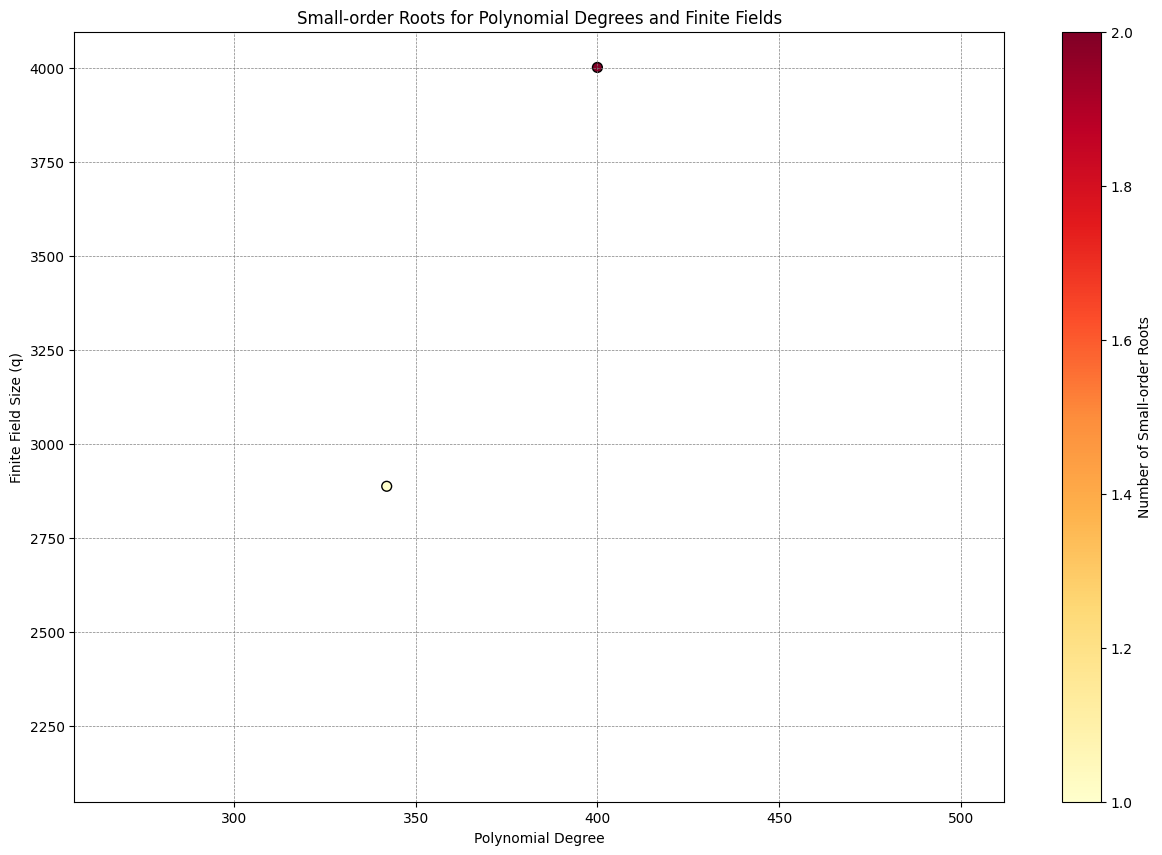

In [47]:
# Create lists to hold x, y coordinates and colors for scatter plot
x_vals = []
y_vals = []
colors = []

# Generate random data for number of small-order roots
grouped_info = group_combinations(list_info_small_roots_generic)
for (p, s, r, q, info_list) in grouped_info:
    if r == 0:
        continue
    degree = (p**(s-1))*(2**(r-2))*(p-1)
    x_vals.append(degree)
    y_vals.append(q)
    colors.append(len(info_list))


# Convert lists to numpy arrays for easier plotting
x_vals = np.array(x_vals)
y_vals = np.array(y_vals)
colors = np.array(colors)

# Plotting
plt.figure(figsize=(15, 10))

# Create scatter plot where circles are drawn for each intersection with non-zero roots
scatter = plt.scatter(x_vals, y_vals, c=colors, cmap='YlOrRd', edgecolors='black', s=50, marker='o')

# Color bar to represent the number of small-order roots
plt.colorbar(scatter, label='Number of Small-order Roots')

# Set labels and title
plt.xlabel('Polynomial Degree')
plt.ylabel('Finite Field Size (q)')
plt.title('Small-order Roots for Polynomial Degrees and Finite Fields')

# Adjust the axes' limits to make the plot more readable
plt.xlim(bottom_n, top_n)
plt.ylim(bottom_q, top_q)

# Add gridlines for visual clarity
plt.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()
